This is a notebook to explore opSim outputs in different ways, mostly useful to supernova analysis. We will look at the opsim output called Enigma_1189

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

In [4]:
# Required packages sqlachemy, pandas (both are part of anaconda distribution, or can be installed with a python installer)
# One step requires the LSST stack, can be skipped for a particular OPSIM database in question
import opsimsummary.summarize_opsim as so
from sqlalchemy import create_engine
import pandas as pd
print so.__file__

/Users/rbiswas/.local/lib/python2.7/site-packages/opsimsummary/summarize_opsim.pyc


In [5]:
# This step requires LSST SIMS package MAF. The main goal of this step is to set DD and WFD to integer keys that 
# label an observation as Deep Drilling or for Wide Fast Deep.
# If you want to skip this step, you can use the next cell by uncommenting it, and commenting out this cell, if all you
# care about is the database used in this example. But there is no guarantee that the numbers in the cell below will work
# on other versions of opsim database outputs

from lsst.sims.maf import db
from lsst.sims.maf.utils import opsimUtils

In [4]:
# DD = 366
# WFD = 364

## Read in OpSim output for modern versions: (sqlite formats)

Description of OpSim outputs are available on the page https://confluence.lsstcorp.org/display/SIM/OpSim+Datasets+for+Cadence+Workshop+LSST2015http://tusken.astro.washington.edu:8080
Here we will use the opsim output http://ops2.tuc.noao.edu/runs/enigma_1189/data/enigma_1189_sqlite.db.gz
I have downloaded this database, unzipped and use the variable dbname to point to its location

In [6]:
# Change dbname to point at your own location of the opsim output
dbname = '/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db'
opsdb = db.OpsimDatabase(dbname)
propID, propTags = opsdb.fetchPropInfo()
DD = propTags['DD'][0]
WFD = propTags['WFD'][0]

In [7]:
print("The propID for the Deep Drilling Field {0:2d}".format(DD))
print("The propID for the Wide Fast Deep Field {0:2d}".format(WFD))

The propID for the Deep Drilling Field 56
The propID for the Wide Fast Deep Field 54


## Read in the OpSim DataBase into a pandas dataFrame

In [8]:
engine = create_engine('sqlite:///' + dbname)

The opsim database is a large file (approx 4.0 GB), but still possible to read into memory on new computers. You usually only need the Summary Table, which is about 900 MB. If you are only interested in the Deep Drilling Fields, you can use the read_sql_query to only select information pertaining to Deep Drilling Observations. This has a memory footprint of about 40 MB.
Obviously, you can reduce this further by narrowing down the columns to those of interest only. For the entire Summary Table, this step takes a few minutes on my computer. 

If you are going to do the read from disk step very often, you can further reduce the time used by storing the output on disk as a hdf5 file and reading that into memory

We will look at three different Summaries of OpSim Runs. A summary of the 
1. Deep Drilling fields: These are the observations corresponding to propID of the variable DD above, and are restricted to a handful of fields
2. WFD (Main) Survey: These are the observations corresponding to the propID of the variables WFD
3. Combined Survey: These are observations combining DEEP and WFD in the DDF. Note that this leads to duplicate observations which must be subsequently dropped.

In [9]:
# Load to a dataframe
# Summary = pd.read_hdf('storage.h5', 'table')
# Summary = pd.read_sql_table('Summary', engine, index_col='obsHistID')
# EnigmaDeep  = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is 366', engine)
# EnigmaD  = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is 366', engine)

If we knew ahead of time the proposal ID, then we could have done this quicker using 

In [68]:
OpSim_combined = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is ' + str(DD) + ' or ' +str(WFD), engine, index_col='obsHistID')

In [67]:
OpSim_Deep = pd.read_sql_query('SELECT * FROM SUMMARY WHERE PROPID is ' + str(DD), engine, index_col='obsHistID')

We can also sub-select this from the all-encompassing Summay Table. This can be done in two way:

## Some properties of the OpSim Outputs

### Construct our Summary

In [70]:
OpSimDeepSummary = so.SummaryOpsim(OpSim_Deep)
OpSimCombinedSummary = so.SummaryOpsim(OpSim_combined)

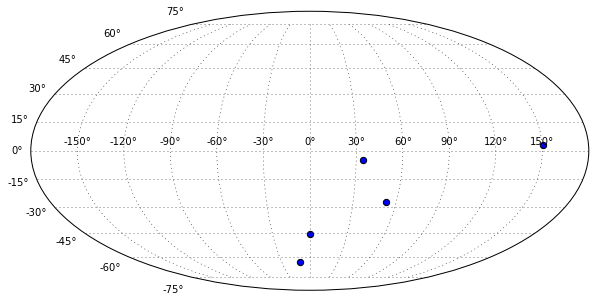

In [71]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide');
fig = OpSimDeepSummary.showFields(ax=fig.axes[0], marker='o', s=40)

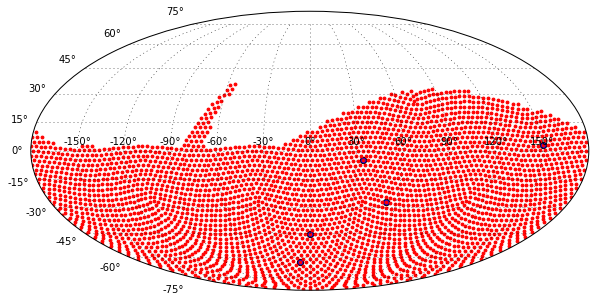

In [73]:
OpSimCombinedSummary.showFields(ax=ax, marker='o', color='r', s=8)

In [14]:
#fieldList = EnigmaDeepSummary.fieldIds

#### First Season

We can visualize the cadence during the first season using the cadence plot for a particular field: The following plot shows how many visits we have in different filters on a particular night:

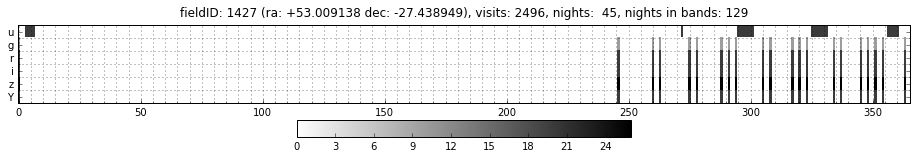

In [75]:
firstSeasonDeep = OpSimDeepSummary.cadence_plot(fieldID=1427, observedOnly=False, sql_query='night < 366')

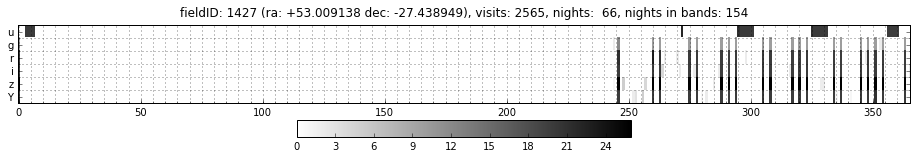

In [78]:
firstSeasonCombined = OpSimCombinedSummary.cadence_plot(fieldID=1427, observedOnly=False, sql_query='night < 366')

In [80]:
firstSeasonCombined[0].savefig('minion_1427.pdf')

In [53]:
firstSeason_main[0].savefig('minion_1430.pdf')

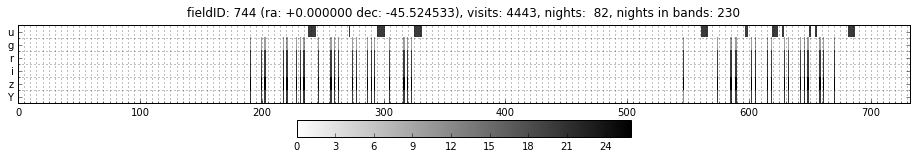

In [83]:
firstSeason = OpSimDeepSummary.cadence_plot(fieldID=744, observedOnly=False, sql_query='night < 732', 
                                             nightMin=0, nightMax=732)

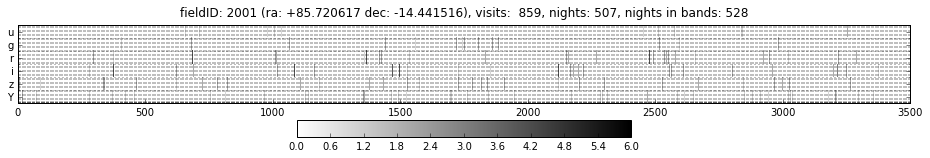

In [84]:
tenCadence = OpSimCombinedSummary.cadence_plot(fieldID=fieldList[2000], observedOnly=False, sql_query='night < 3500', nightMax=3500)

Suppose we have a supernova with a peak around a particular MJD of 49540, and we want to see what the observations happened around it:

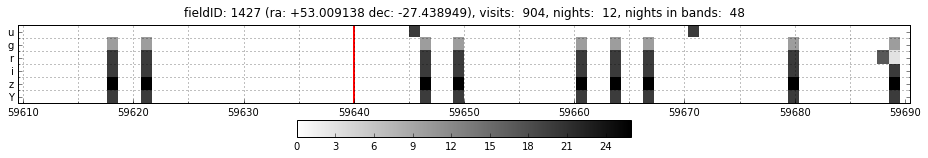

In [94]:
SN = OpSimDeepSummary.cadence_plot(summarydf=OpSimDeepSummary.df, fieldID=1427, #racol='fieldRA', deccol='fieldDec',
                                                  observedOnly=False, mjd_center=59640., mjd_range=[-30., 50.])
# ax = plt.gca()
# ax.axvline(49540, color='r', lw=2.)
# ax.xaxis.get_major_formatter().set_useOffset(False)

In [96]:
SN[0].savefig('SN_observaton.pdf')

# Scratch

In [ ]:
SN_matrix.sum(axis=1).sum()

In [ ]:
EnigmaDeep.query('fieldID == 744 and expMJD < 49590 and expMJD > 49510').expMJD.size

In [41]:
SN_matrix[SN_matrix > 0.5] = 1

In [52]:
SN_matrix.sum().sum()

336.0

In [55]:
len(SN_matrix.sum(axis=1).dropna())

7

In [56]:
nightlySN_matrix = SN_matrix.copy(deep=True)

In [57]:
nightlySN_matrix[SN_matrix > 0.5] =1

In [64]:
nightlySN_matrix.sum(axis=1).dropna().sum()

18.0

In [69]:
nightlySN_matrix.sum(axis=1).dropna().size

7

In [ ]:
nightlySN_matrix.sum(ax)